# Inverse scattering for circular billiard

## Importação das bibliotecas

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import utils.Utils as utils
import utils.GenerateData as generateData
import model.GeneralizedMLP as gMLP

## Lendo os dados

In [26]:
df = pd.read_csv('./data/dados.csv')

In [27]:
df

,M,HBAR,k_min,k_max,delta_k,n_min,n_max,gamma,R,l_k1,...,l_k587,l_k588,l_k589,l_k590,l_k591,l_k592,l_k593,l_k594,l_k595,l_k596
0,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,0.1,0.100000,0.155397,...,0.001165,0.001162,0.001160,0.001158,0.001156,0.001154,0.001151,0.001149,0.001147,0.001145
1,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,0.1,0.110053,0.184685,...,0.001384,0.001382,0.001379,0.001376,0.001374,0.001371,0.001368,0.001366,0.001363,0.001360
2,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,0.1,0.120106,0.215951,...,0.001616,0.001613,0.001610,0.001607,0.001603,0.001600,0.001597,0.001594,0.001591,0.001587
3,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,0.1,0.130159,0.249095,...,0.001859,0.001855,0.001851,0.001847,0.001843,0.001839,0.001836,0.001832,0.001828,0.001824
4,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,0.1,0.140212,0.284026,...,0.002109,0.002105,0.002100,0.002096,0.002091,0.002087,0.002082,0.002078,0.002073,0.002069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55095,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,3.0,1.959788,34.509730,...,9.570126,9.597571,9.622035,9.642763,9.658887,9.669430,9.673316,9.669396,9.656485,9.633432
55096,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,3.0,1.969841,34.602123,...,9.705567,9.723303,9.735533,9.741150,9.738963,9.727735,9.706246,9.673381,9.628239,9.570257
55097,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,3.0,1.979894,34.694353,...,9.808430,9.808259,9.799045,9.779501,9.748425,9.704819,9.648019,9.577836,9.494682,9.399662
55098,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,3.0,1.989947,34.786420,...,9.853002,9.824148,9.782554,9.727437,9.658485,9.576006,9.481020,9.375310,9.261361,9.142220


## Plot da scattering cross length para gamma, R = 2.0

In [28]:
df_R_2 = df[df['R'] == 2.0]

In [ ]:
row_gamma_R_2 = df_R_2[(df_R_2['gamma'] > 1.97) & (df_R_2['gamma'] < 2.03)]

In [ ]:
row_gamma_R_2

In [ ]:
l_array = row_gamma_R_2.drop(columns=['M', 'HBAR', 'k_min', 'k_max', 'delta_k', 'n_min', 'n_max', 'gamma', 'R']).to_numpy()

In [ ]:
l_array.shape

In [ ]:
k_min = 0.02
k_max = 3.0
k = np.linspace(k_min, k_max, 596)

fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(k, l_array[0], ls='-', label=f"$\gamma = 1.97$")
axes.plot(k, l_array[1], ls='-', label=f"$\gamma = 1.98$")
axes.plot(k, l_array[2], ls='-', label=f"$\gamma = 1.99$")
axes.plot(k, l_array[3], ls='-', label=f"$\gamma = 2.00$")
axes.plot(k, l_array[4], ls='-', label=f"$\gamma = 2.01$")
axes.plot(k, l_array[5], ls='-', label=f"$\gamma = 2.02$")
axes.set_title(f'Scattering cross length values')
axes.set_xlabel(f'k')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

## Implementação da rede neural

### Definição dos inputs da rede

In [29]:
features = df.drop(columns=['gamma', 'R'])

features = features.to_numpy()

In [30]:
targets = df[['gamma', 'R']]

targets = targets.to_numpy()

In [31]:
print(features.shape)
print(targets.shape)

(55100, 603)
(55100, 2)


### Definição da rede neural

A rede neural implementada é uma rede neural do tipo Multilayer Perceptron

### Variáveis para o modelo, separação dos dados de teste e treino e etc

In [32]:
train, test_data = train_test_split(features, test_size = 0.2, random_state = 2)
real_train_data, validation_data = train_test_split(train, test_size = 0.3, random_state = 2)

train_target, test_target = train_test_split(targets, test_size = 0.2, random_state = 2)
real_train_target, validation_target = train_test_split(train_target, test_size = 0.3, random_state = 2)

input_size = 603
output_size = 2
batch_size = 256
num_epochs = 1000
learning_rate = 0.0001

In [33]:
train_loader, val_loader, test_loader = utils.prepare_data(real_train_data, real_train_target, test_data, test_target, validation_data, validation_target, batch_size)

Input Shapes:
torch.Size([30856, 603]) torch.Size([13224, 603]) torch.Size([11020, 603])
Target Shapes:
torch.Size([30856, 2]) torch.Size([13224, 2]) torch.Size([11020, 2])


### Primeira rodada de treinamento

In [34]:
# nums_neurons = [20, 40, 60, 80, 100, 140, 180, 220, 260, 300, 340, 380, 420]
running_loss_total_arrays = []
val_loss_total_arrays = []
test_loss_total = []

# for num in nums_neurons:
    
model = gMLP.GeneralizedMLP(input_size, output_size, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train and evaluate the model
running_loss_array, val_loss_array = gMLP.train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)

running_loss_total_arrays.append(running_loss_array)
val_loss_total_arrays.append(val_loss_array)
outputs, test_loss = gMLP.evaluate_model(model, criterion, test_loader)
test_loss_total.append(test_loss)

# torch.save(model.state_dict(), 'mlp_weights.pth')

hidden neurons:  404
Epoch 1/1000, Training Loss: 0.2502892801214841, Validation Loss: 0.08702005875798371
Epoch 2/1000, Training Loss: 0.0696423684577804, Validation Loss: 0.055210116892479934
Epoch 3/1000, Training Loss: 0.05130940629554189, Validation Loss: 0.04480078128667978
Epoch 4/1000, Training Loss: 0.042724977578382846, Validation Loss: 0.03814808469122419
Epoch 5/1000, Training Loss: 0.03751189290923028, Validation Loss: 0.03396243688005667
Epoch 6/1000, Training Loss: 0.03385868799403187, Validation Loss: 0.03146742312954022
Epoch 7/1000, Training Loss: 0.03136806585633558, Validation Loss: 0.029099107684137728
Epoch 8/1000, Training Loss: 0.02938119914721359, Validation Loss: 0.027255952143325254
Epoch 9/1000, Training Loss: 0.02777405338715916, Validation Loss: 0.025844309478998184
Epoch 10/1000, Training Loss: 0.026411051861941814, Validation Loss: 0.024635628295632508
Epoch 11/1000, Training Loss: 0.025371664319156616, Validation Loss: 0.023736825499397058
Epoch 12/1000

In [ ]:
# fig = plt.figure(figsize=(8,6))
# axes = fig.add_axes([0.1,0.1,0.8,0.8])
# # plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
# for running_loss in running_loss_total_arrays:
#     index = running_loss_total_arrays.index(running_loss)
#     num_neurons_used = nums_neurons[index]
#     axes.plot(running_loss, ls='-', label=f"{num_neurons_used} neurons")

# axes.set_title(f'Training loss for each neurons number')
# axes.set_xlabel(f'epochs')
# axes.legend(loc='upper right')
# plt.grid(linestyle='-', linewidth=0.5)

In [ ]:
# fig = plt.figure(figsize=(8,6))
# axes = fig.add_axes([0.1,0.1,0.8,0.8])

# for val_loss in val_loss_total_arrays:
#     index = val_loss_total_arrays.index(val_loss)
#     num_neurons_used = nums_neurons[index]
#     axes.plot(val_loss, ls='-', label=f"{num_neurons_used} neurons")

# axes.set_title(f'Cross validation loss for each neurons number')
# axes.set_xlabel(f'epochs')
# axes.legend(loc='upper right')
# plt.grid(linestyle='-', linewidth=0.5)

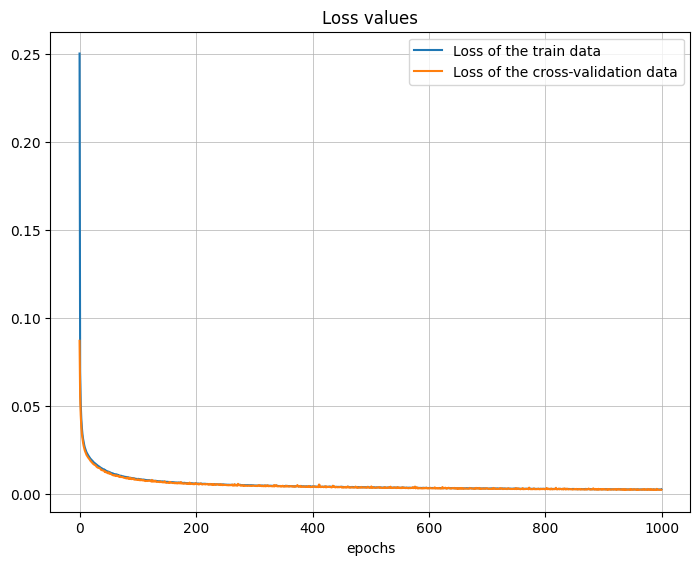

In [35]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
list_train = running_loss_total_arrays[0]
list_val = val_loss_total_arrays[0]


axes.plot(list_train, ls='-', lw=1.5, label='Loss of the train data')
axes.plot(list_val, ls='-', lw=1.5, label='Loss of the cross-validation data')

axes.set_title(f'Loss values')
axes.set_xlabel(f'epochs')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

In [12]:
# fig = plt.figure(figsize=(8,6))
# axes = fig.add_axes([0.1,0.1,0.8,0.8])
# list_train = []
# list_val = []
# for val_loss in val_loss_total_arrays:
#     avg = 0
#     for val in val_loss[-10:]:
#         avg = avg + (val/20.0)
#     list_val.append(avg)

# for train_loss in running_loss_total_arrays:
#     avg = 0
#     for train in train_loss[-10:]:
#         avg = avg + (train/20.0)
    
#     list_train.append(avg)


# # >>> a=axes.get_xticks().tolist()
# # >>> a[1]='change'
# # >>> axes.set_xticklabels(a)

# axes.plot(nums_neurons, list_train, ls='-.', lw=2, label='Average loss of the train data')
# axes.plot(nums_neurons, list_val, ls='-.', lw=2, label='Average loss of cross-validation data')

# axes.set_title(f'Average loss of the last 20 epochs')
# axes.set_xlabel(f'Number of hidden neurons')
# axes.legend(loc='upper right')
# plt.grid(linestyle='-', linewidth=0.5)

### Segunda rodada de treinamento

In [36]:
saved_state_dict = torch.load('mlp_weights.pth')

# Initialize the new model
extended_model = gMLP.GeneralizedMLP(input_size, output_size, 2)

# Copy the weights of the hidden_layer to hidden_layer1

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
running_loss_array, val_loss_array = gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)

running_loss_total_arrays.append(running_loss_array)
val_loss_total_arrays.append(val_loss_array)
outputs, test_loss = gMLP.evaluate_model(extended_model, criterion, test_loader)
test_loss_total.append(test_loss)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

hidden neurons:  404
Epoch 1/1000, Training Loss: 0.4767365705006379, Validation Loss: 0.09325367957353592
Epoch 2/1000, Training Loss: 0.060285454908432054, Validation Loss: 0.03996547021401616
Epoch 3/1000, Training Loss: 0.0321777599348017, Validation Loss: 0.025272884943450872
Epoch 4/1000, Training Loss: 0.02270630673959482, Validation Loss: 0.019386059479214825
Epoch 5/1000, Training Loss: 0.018709425421908867, Validation Loss: 0.01669368054717779
Epoch 6/1000, Training Loss: 0.01664182990173663, Validation Loss: 0.014921658475381823
Epoch 7/1000, Training Loss: 0.015209218133087, Validation Loss: 0.01386574276078206
Epoch 8/1000, Training Loss: 0.014146525451282331, Validation Loss: 0.013014663951113246
Epoch 9/1000, Training Loss: 0.01325412575648097, Validation Loss: 0.012182903117858447
Epoch 10/1000, Training Loss: 0.012634765934045156, Validation Loss: 0.011557842112289598
Epoch 11/1000, Training Loss: 0.012037649773800176, Validation Loss: 0.01111652383294243
Epoch 12/1000

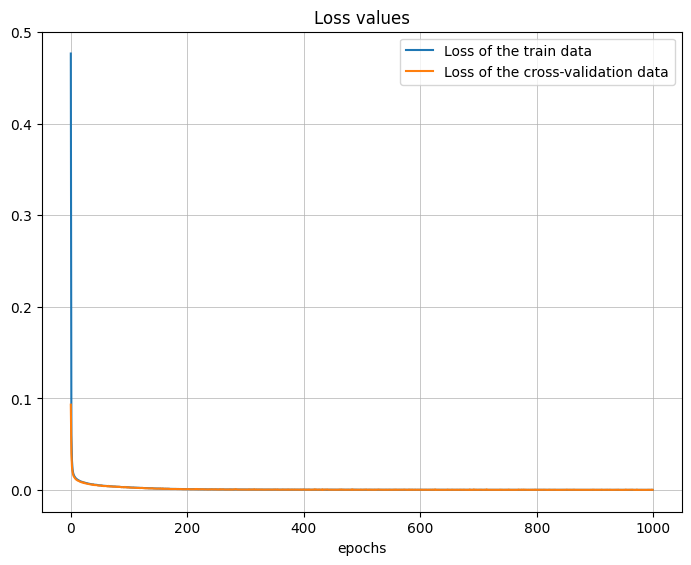

In [37]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
list_train = running_loss_total_arrays[1]
list_val = val_loss_total_arrays[1]


axes.plot(list_train, ls='-', lw=1.5, label='Loss of the train data')
axes.plot(list_val, ls='-', lw=1.5, label='Loss of the cross-validation data')

axes.set_title(f'Loss values')
axes.set_xlabel(f'epochs')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

### Terceira rodada de treinamento

In [38]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 3)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 2):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})

criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
running_loss_array, val_loss_array = gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)

running_loss_total_arrays.append(running_loss_array)
val_loss_total_arrays.append(val_loss_array)
outputs, test_loss = gMLP.evaluate_model(extended_model, criterion, test_loader)
test_loss_total.append(test_loss)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')


hidden neurons:  404
Epoch 1/1000, Training Loss: 0.3854980964429122, Validation Loss: 0.04807245093755997
Epoch 2/1000, Training Loss: 0.020637789641099035, Validation Loss: 0.009811276641602699
Epoch 3/1000, Training Loss: 0.007979859293954185, Validation Loss: 0.006148491229396313
Epoch 4/1000, Training Loss: 0.0055828507804919865, Validation Loss: 0.0046813153984168404
Epoch 5/1000, Training Loss: 0.004311687347656193, Validation Loss: 0.003612134350427928
Epoch 6/1000, Training Loss: 0.003596065211887202, Validation Loss: 0.0030182334437715607
Epoch 7/1000, Training Loss: 0.0030298995389025814, Validation Loss: 0.0026902506495109545
Epoch 8/1000, Training Loss: 0.0026810015263112864, Validation Loss: 0.0023559691169514107
Epoch 9/1000, Training Loss: 0.0023763787284231752, Validation Loss: 0.0020490971667011483
Epoch 10/1000, Training Loss: 0.0021674888639533815, Validation Loss: 0.001866204682021187
Epoch 11/1000, Training Loss: 0.001971247857571233, Validation Loss: 0.0018035468

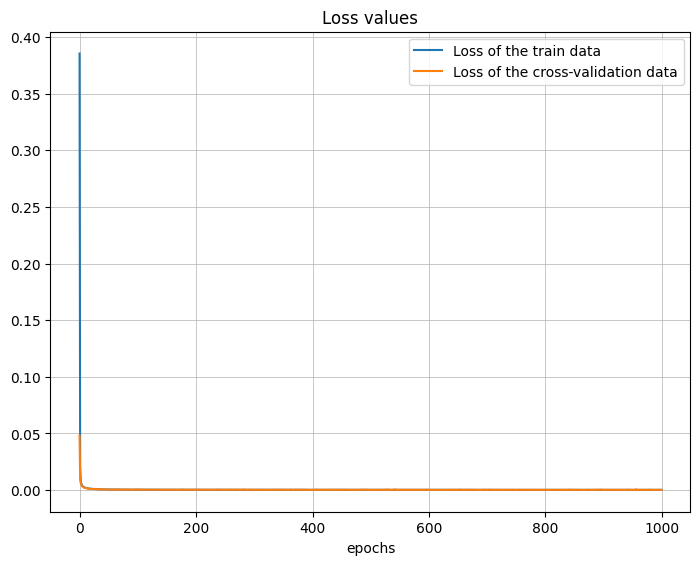

In [39]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
list_train = running_loss_total_arrays[2]
list_val = val_loss_total_arrays[2]


axes.plot(list_train, ls='-', lw=1.5, label='Loss of the train data')
axes.plot(list_val, ls='-', lw=1.5, label='Loss of the cross-validation data')

axes.set_title(f'Loss values')
axes.set_xlabel(f'epochs')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

In [ ]:
# fig = plt.figure(figsize=(8,6))
# axes = fig.add_axes([0.1,0.1,0.8,0.8])
# list_train = []
# list_val = []
# for val_loss in val_loss_total_arrays:
#     avg = 0
#     for val in val_loss[-10:]:
#         avg = avg + (val/20.0)
#     list_val.append(avg)

# for train_loss in running_loss_total_arrays:
#     avg = 0
#     for train in train_loss[-10:]:
#         avg = avg + (train/20.0)
    
#     list_train.append(avg)


# # >>> a=axes.get_xticks().tolist()
# # >>> a[1]='change'
# # >>> axes.set_xticklabels(a)

# axes.plot(nums_neurons, list_train, ls='-.', lw=2, label='Average loss of the train data')
# axes.plot(nums_neurons, list_val, ls='-.', lw=2, label='Average loss of cross-validation data')

# axes.set_title(f'Average loss of the last 20 epochs - 3rd run')
# axes.set_xlabel(f'Number of hidden neurons')
# axes.legend(loc='upper right')
# plt.grid(linestyle='-', linewidth=0.5)

#### Quarta rodada de treinamento

In [40]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 4)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 3):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})
    
criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
running_loss_array, val_loss_array = gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)

running_loss_total_arrays.append(running_loss_array)
val_loss_total_arrays.append(val_loss_array)
outputs, test_loss = gMLP.evaluate_model(extended_model, criterion, test_loader)
test_loss_total.append(test_loss)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

hidden neurons:  404
Epoch 1/1000, Training Loss: 0.4718645154075189, Validation Loss: 0.1063558582503062
Epoch 2/1000, Training Loss: 0.03517935498933161, Validation Loss: 0.007813645311846184
Epoch 3/1000, Training Loss: 0.004461944453449042, Validation Loss: 0.0026467622195083937
Epoch 4/1000, Training Loss: 0.002043313440127868, Validation Loss: 0.0015660704028470297
Epoch 5/1000, Training Loss: 0.001380527408866689, Validation Loss: 0.001170269665845598
Epoch 6/1000, Training Loss: 0.001033528452481274, Validation Loss: 0.0008432545985739965
Epoch 7/1000, Training Loss: 0.0008487407226800488, Validation Loss: 0.0007041427642644311
Epoch 8/1000, Training Loss: 0.0007242485796667112, Validation Loss: 0.0007190933236135886
Epoch 9/1000, Training Loss: 0.0006394848407415503, Validation Loss: 0.0005831950592647234
Epoch 10/1000, Training Loss: 0.000597373962937277, Validation Loss: 0.0004970453944854223
Epoch 11/1000, Training Loss: 0.0005017377669232213, Validation Loss: 0.00070495927

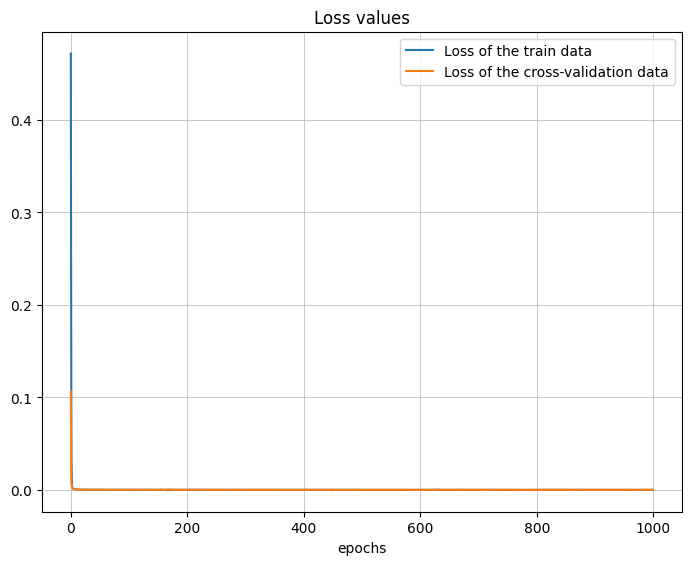

In [41]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
list_train = running_loss_total_arrays[3]
list_val = val_loss_total_arrays[3]

axes.plot(list_train, ls='-', lw=1.5, label='Loss of the train data')
axes.plot(list_val, ls='-', lw=1.5, label='Loss of the cross-validation data')

axes.set_title(f'Loss values')
axes.set_xlabel(f'epochs')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

### Quinta rodada

In [42]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 5)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 4):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})
    
criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
running_loss_array, val_loss_array = gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)

running_loss_total_arrays.append(running_loss_array)
val_loss_total_arrays.append(val_loss_array)
outputs, test_loss = gMLP.evaluate_model(extended_model, criterion, test_loader)
test_loss_total.append(test_loss)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

hidden neurons:  404
Epoch 1/1000, Training Loss: 0.48628700666191166, Validation Loss: 0.14140795486477706
Epoch 2/1000, Training Loss: 0.05132726560662354, Validation Loss: 0.009918262877573188
Epoch 3/1000, Training Loss: 0.005176978180000235, Validation Loss: 0.0028070670265990952
Epoch 4/1000, Training Loss: 0.0020225709236865817, Validation Loss: 0.00152902077892437
Epoch 5/1000, Training Loss: 0.0012172096411789928, Validation Loss: 0.0010277684565293244
Epoch 6/1000, Training Loss: 0.0008448398468076936, Validation Loss: 0.0006960633730229277
Epoch 7/1000, Training Loss: 0.0006289011067595364, Validation Loss: 0.0005781923145360241
Epoch 8/1000, Training Loss: 0.000519825211506768, Validation Loss: 0.0004581369441719009
Epoch 9/1000, Training Loss: 0.0004393843093777291, Validation Loss: 0.0005409107677853451
Epoch 10/1000, Training Loss: 0.000368911815900548, Validation Loss: 0.0003229186519232686
Epoch 11/1000, Training Loss: 0.0003796653867283574, Validation Loss: 0.00034706

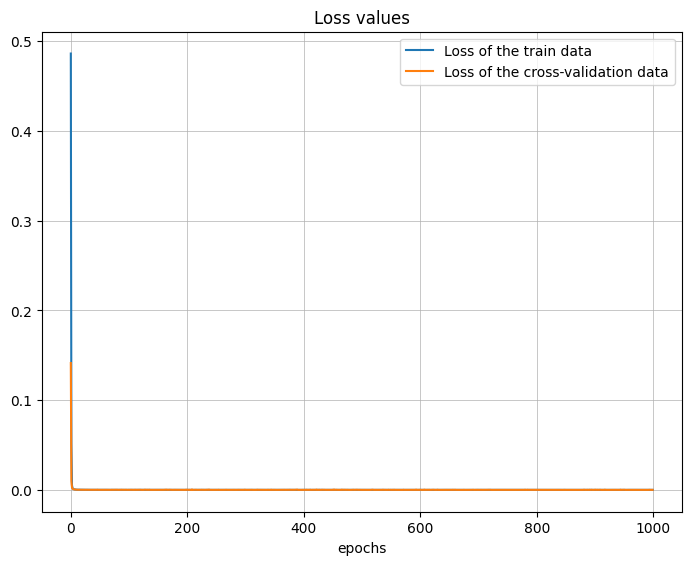

In [43]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
list_train = running_loss_total_arrays[4]
list_val = val_loss_total_arrays[4]


axes.plot(list_train, ls='-', lw=1.5, label='Loss of the train data')
axes.plot(list_val, ls='-', lw=1.5, label='Loss of the cross-validation data')

axes.set_title(f'Loss values')
axes.set_xlabel(f'epochs')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

#### Sexta rodada

In [44]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 6)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 5):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})
    
criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
running_loss_array, val_loss_array = gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)

running_loss_total_arrays.append(running_loss_array)
val_loss_total_arrays.append(val_loss_array)
outputs, test_loss = gMLP.evaluate_model(extended_model, criterion, test_loader)
test_loss_total.append(test_loss)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

hidden neurons:  404
Epoch 1/1000, Training Loss: 0.41506543136702095, Validation Loss: 0.07022733972049676
Epoch 2/1000, Training Loss: 0.023847142111294527, Validation Loss: 0.006652801136414592
Epoch 3/1000, Training Loss: 0.0036374568027128613, Validation Loss: 0.002173227746075449
Epoch 4/1000, Training Loss: 0.0015262026562978905, Validation Loss: 0.0011062902530494074
Epoch 5/1000, Training Loss: 0.0008883021871967257, Validation Loss: 0.0006939723713842866
Epoch 6/1000, Training Loss: 0.000611116485968463, Validation Loss: 0.0005090186034347146
Epoch 7/1000, Training Loss: 0.0004518099716327669, Validation Loss: 0.00038766649735267635
Epoch 8/1000, Training Loss: 0.0003495494359315273, Validation Loss: 0.00041989177687075705
Epoch 9/1000, Training Loss: 0.00030888580286121074, Validation Loss: 0.0002841828460917056
Epoch 10/1000, Training Loss: 0.00025890083273503284, Validation Loss: 0.00023820626665838063
Epoch 11/1000, Training Loss: 0.0002429891609916779, Validation Loss: 0

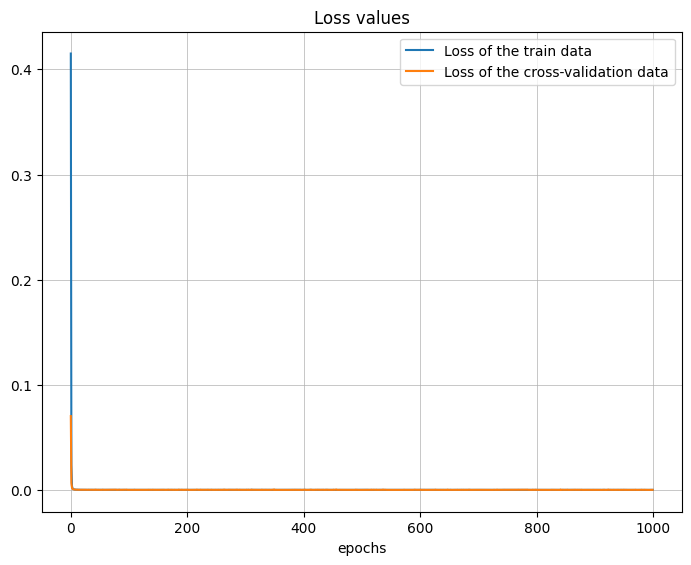

In [45]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
list_train = running_loss_total_arrays[5]
list_val = val_loss_total_arrays[5]


axes.plot(list_train, ls='-', lw=1.5, label='Loss of the train data')
axes.plot(list_val, ls='-', lw=1.5, label='Loss of the cross-validation data')

axes.set_title(f'Loss values')
axes.set_xlabel(f'epochs')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

breakpoint!

In [46]:
# data_list = [
#     [1, 2, 3, ..., 150],  # run_1
#     [4, 5, 6, ..., 150],  # run_2
#     [7, 8, 9, ..., 150],  # run_3
#     [10, 11, 12, ..., 150],  # run_4
#     [13, 14, 15, ..., 150],  # run_5
#     [16, 17, 18, ..., 150],  # run_6
# ]

# Transpondo a lista para obter o formato desejado (6 colunas e 150 linhas)
data_transposed = list(zip(*running_loss_total_arrays))

# Criando o DataFrame
df = pd.DataFrame(data_transposed, columns=[f'run_{i+1}' for i in range(6)])

# Salvando em um arquivo CSV
df.to_csv('dados_train_loss_runs_3.csv', index=False)

print("Arquivo CSV salvo com sucesso.")

Arquivo CSV salvo com sucesso.


In [47]:
# Transpondo a lista para obter o formato desejado (6 colunas e 150 linhas)
data_transposed = list(zip(*val_loss_total_arrays))

# Criando o DataFrame
df = pd.DataFrame(data_transposed, columns=[f'run_{i+1}' for i in range(6)])

# Salvando em um arquivo CSV
df.to_csv('dados_val_loss_runs_3.csv', index=False)

print("Arquivo CSV salvo com sucesso.")

Arquivo CSV salvo com sucesso.


### Sétima rodada

In [ ]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 7)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 6):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})
    
criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)
gMLP.evaluate_model(extended_model, criterion, test_loader)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

### Oitava rodada

In [ ]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 8)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 7):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})
    
criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)
gMLP.evaluate_model(extended_model, criterion, test_loader)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

#### Nona rodada

In [ ]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 9)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 8):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})
    
criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)
gMLP.evaluate_model(extended_model, criterion, test_loader)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

### Décima rodada

In [ ]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 10)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 9):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})
    
criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)
gMLP.evaluate_model(extended_model, criterion, test_loader)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

### Prediction to R = 2 and gamma = 2

In [ ]:
# evaluate_model(extended_model, criterion, test_loader)
test_target.shape

In [ ]:
row_gamma_R_2

In [ ]:
row_gamma2_R_2 = row_gamma_R_2[(row_gamma_R_2['gamma'] > 2.0) & (row_gamma_R_2['gamma'] < 2.01)]

In [ ]:
row_gamma2_R_2

In [ ]:
inputs_row_gamma2_R_2 = row_gamma2_R_2.drop(columns=['gamma', 'R'])
inputs_row_gamma2_R_2 = inputs_row_gamma2_R_2.to_numpy()

In [ ]:
inputs_row_gamma2_R_2.shape

In [ ]:
test_r2_gamma2 = np.array([[2.0], [2.0]]).transpose()

In [ ]:
test_r2_gamma2.shape

In [ ]:
inputs_tensor_row_gamma2_R_2 = torch.tensor(inputs_row_gamma2_R_2, dtype=torch.float32)
target_test_r2_gamma2 = torch.tensor(test_r2_gamma2, dtype=torch.float32)

In [ ]:
test_r2_gamma2_dataset = torch.utils.data.TensorDataset(inputs_tensor_row_gamma2_R_2, target_test_r2_gamma2)
test_r2_gamma2_loader = torch.utils.data.DataLoader(test_r2_gamma2_dataset, batch_size=1, shuffle=False)

In [ ]:
outputs = gMLP.evaluate_model(extended_model, criterion, test_r2_gamma2_loader)
outputs

In [ ]:
predicted = outputs.squeeze().tolist()
predicted_gamma_R = np.array(predicted)

In [ ]:
print('Considerando os dados para R = 2.0 e gamma = 2.0')
print('Os valores obtidos foram: ')
print('gamma: ', predicted_gamma_R[0])
print('R: ', predicted_gamma_R[1])
print('Erro quadrático médio: ', 0.00016762154700700194)

In [ ]:
gamma = predicted_gamma_R[0]
r = predicted_gamma_R[1]

cross_section = generateData.circularBarrierCrossSection(gamma, r, -20, 20, 0.02, 3.0, 596)

In [ ]:
cross_section

In [ ]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(k, l_array[3], ls='-', label=f"True value")
axes.plot(k, cross_section, ls='-', label=f"Predicted value")
axes.set_title(f'Scattering cross length values')
axes.set_xlabel(f'k')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

In [ ]:
import matplotlib

u = np.linspace(0, 2 * np.pi, 100)

x_real, y_real = 2.0 * np.cos(u), 2.0 * np.sin(u)
x_predicted, y_predicted = r * np.cos(u), r * np.sin(u)

In [ ]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(x_real, y_real, ls='-', lw=1.0, label=f"True value")
axes.plot(x_predicted, y_predicted, ls='-', lw=1.0, label=f"Predicted value")
axes.set_title(f'Barrier')
axes.set_xlabel(f'x')
axes.set_xlabel(f'y')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

In [ ]:
input_size = 603
output_size = 2
rule_1 = max(input_size, output_size)
rule_2 = int(2/3 * input_size + output_size)
rule_3 = min(2 * input_size - 1, input_size + input_size // 3)
hidden_neurons = min(rule_1, rule_2, rule_3)

hidden_neurons